# Arena data preparation

This notebook aims to generate data necessary for demoing the Arena tool.

We want to prepare data for evaluating both text-only as well as multimodal datasets, and for that we want to:
- [ ] Prepare `mtsamples-gpt4` for evaluation of two models;
- [x] Generate results for `VQA-Rad`;
    - [x] Prepare variation of VQA-Rad for the grounded report generation task.
- [x] Prepare `segmed` images for comparison of CXRReportGen with gpt-4o.

## Pre-requisites

To run the notebook, you need to:
- Follow `Getting started` instructions from the README file.
- Run `az login`.
- If using CXRReportGen, please activate your Contributor role for the `MedicalImagingAI Dev` subscription in the portal.

## Dependencies

In [ ]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), "../.."))


In [2]:
%load_ext autoreload
%autoreload 2

import base64
import json

from dotenv import load_dotenv

from medbench.aml import AzureML
from medbench.config import settings
from medbench.datasets import Data, Dataset, EMediaObjectType, Instance, MediaObject
from medbench.datasets.vqarad import get_vqarad_dataset, get_vqarad_findings_dataset
from medbench.experiments import Experiment
from medbench.models import ModelRun
from medbench.models.cxrreportgen import CXRReportGenModel, CXRReportGenRunner
from medbench.models.azureoai import (
    AzureOpenAIRunner,
    OpenAIChatModel,
    OpenAIReasoningModel,
)

load_dotenv("../.env")


2025-03-20 09:06:05.227 | INFO     | medbench.config:from_env:59 - Environment variable AZURE_STORAGE_ACCOUNT_NAME not found.
2025-03-20 09:06:05.229 | INFO     | medbench.config:from_env:59 - Environment variable MEDBENCH_AML_WORKSPACE_NAME not found.
2025-03-20 09:06:05.233 | INFO     | medbench.config:from_env:59 - Environment variable BABELBENCH_AML_WORKSPACE_NAME not found.


True

## Load data

In [3]:
aml = AzureML.connect_to_registry(registry_name="azureml-1p")

HttpResponseError: Operation returned an invalid status 'User/tenant/subscription is not allowed to access registry azureml-1p'
Content: {
  "error": {
    "code": "UserError",
    "severity": null,
    "message": "User/tenant/subscription is not allowed to access registry azureml-1p",
    "messageFormat": "User/tenant/subscription is not allowed to access registry {feedName}",
    "messageParameters": {
      "feedName": "azureml-1p"
    },
    "referenceCode": null,
    "detailsUri": null,
    "target": null,
    "details": [],
    "innerError": {
      "code": "Auth",
      "innerError": {
        "code": "Authorization",
        "innerError": {
          "code": "UnAuthorizedRegistryAccess",
          "innerError": null
        }
      }
    },
    "debugInfo": null,
    "additionalInfo": null
  },
  "correlation": {
    "operation": "d4ac4dc2768e3952d3f13b6abbbe9528",
    "request": "fd27ea1effdb37b0"
  },
  "environment": "eastus",
  "location": "eastus",
  "time": "2025-03-19T17:52:05.6403711+00:00",
  "componentName": "feedmanagement",
  "statusCode": 403
}

In [ ]:
vqarad_df = aml.get_dataset(name="vqarad", version="1", read_folder_jsonl=True)
vqarad_df

2025-03-07 14:30:03.104 | DEBUG    | medbench.aml:get_dataset:130 - Downloading vqa_rad_test.jsonl to temporary directory `/tmp/tmpggri43_i`...
2025-03-07 14:30:19.925 | INFO     | medbench.aml:get_dataset:135 - Reading vqa_rad_test.jsonl as a pandas DataFrame.
/home/lschettini/dev/microsoft/medbench/medbench/notebooks/../medbench/aml.py:138: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  return pd.read_json(jsonl_str, lines=True)


,qid,phrase_type,qid_linked_id,image_case_url,image_name,image_organ,evaluation,question,question_rephrase,question_relation,question_frame,question_type,answer,answer_type,data,query,answers
0,10,test_freeform,3fe4dfe4-015f-4a25-aa33-66c76918105a,https://medpix.nlm.nih.gov/case?id=31ac9c0f-73...,synpic42202.jpg,CHEST,not evaluated,Is there evidence of an aortic aneurysm?,NULL,NULL,NULL,PRES,yes,CLOSED,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,Is there evidence of an aortic aneurysm?,[yes]
1,12,test_freeform,4f49fe02-5652-4f52-878f-dce6bb117bb9,https://medpix.nlm.nih.gov/case?id=b197277b-69...,synpic29265.jpg,CHEST,not evaluated,Is there airspace consolidation on the left side?,NULL,NULL,NULL,PRES,Yes,CLOSED,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,Is there airspace consolidation on the left side?,[Yes]
2,13,test_freeform,512dce25-ab03-4df0-8663-a1b16a8a427b,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...,synpic54610.jpg,HEAD,given,Is this an axial plane?,NULL,NULL,NULL,PLANE,yes,CLOSED,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,Is this an axial plane?,[yes]
3,19,test_freeform,9086a298-c1f4-44fb-ad69-772a30c4e97e,https://medpix.nlm.nih.gov/case?id=b197277b-69...,synpic29265.jpg,CHEST,not evaluated,How is the patient oriented?,NULL,NULL,NULL,OTHER,Posterior-Anterior,OPEN,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,How is the patient oriented?,[Posterior-Anterior]
4,21,test_freeform,a325b7cb-2128-4c58-b108-3c5438b03181,https://medpix.nlm.nih.gov/case?id=48e1dd0e-85...,synpic54610.jpg,HEAD,not evaluated,Is there vascular pathology in this image?,NULL,NULL,NULL,ABN,yes,CLOSED,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,Is there vascular pathology in this image?,[yes]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,1963,test_freeform,ae6a7d9d-db0d-4a8c-8c92-77dd940abd8c,https://medpix.nlm.nih.gov/case?id=0ad3f95b-69...,synpic23571.jpg,ABD,evaluated,Where Is there obstruction present?,"Where is obstruction present, if any?",strict agreement,Where is/are the obstruction located?,POS,proximal aspect of the appendix,OPEN,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,"Where is obstruction present, if any?",[proximal aspect of the appendix]
447,1964,test_para,ae6a7d9d-db0d-4a8c-8c92-77dd940abd8c,https://medpix.nlm.nih.gov/case?id=0ad3f95b-69...,synpic23571.jpg,ABD,evaluated,"Where is obstruction present, if any?",Is there obstruction present? Where?,strict agreement,Where is/are the obstruction located?,POS,proximal aspect of the appendix,OPEN,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,Is there obstruction present? Where?,[proximal aspect of the appendix]
448,1993,test_freeform,de95925a-58ac-440d-8c5f-16d4ff99b1f8,https://medpix.nlm.nih.gov/case?id=35b227cb-fa...,synpic47191.jpg,ABD,not evaluated,Is the GI tract is highlighted by contrast?,NULL,NULL,NULL,"PRES, COLOR",yes,CLOSED,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,Is the GI tract is highlighted by contrast?,[yes]
449,1997,test_para,eb20aa92-ea5f-47f9-99a4-8a2b1b8790f3,https://medpix.nlm.nih.gov/case?id=e47494b5-fe...,synpic676.jpg,CHEST,evaluated,Do you see cardiomegaly?,Is there cardiomegaly present?,strict agreement,Is the heart enlarged?,SIZE,No,CLOSED,/9j/4AAQSkZJRgABAgAAAQABAAD/2wBDAAgGBgcGBQgHBw...,Is there cardiomegaly present?,[No]


In [4]:
description = "A dataset of clinically generated visual questions and answers about radiology images. there is a split called vqa_rad_chest where only chest x ray is included",
vqarad_dataset = get_vqarad_dataset(
    vqarad_df,
    description=description,
)
vqarad_findings_dataset = get_vqarad_findings_dataset(
    vqarad_df,
    description="Modified version of the VQARAD dataset for Image to findings task",
)

NameError: name 'vqarad_df' is not defined

### Save dataset

In [6]:
# Dumpt all jsons into files
for instance in vqarad_dataset.instances:
    with open(f"../data/arena/vqarad/{instance.id}.json", "w+") as f:
        f.write(json.dumps(instance.to_json(), indent=4))

## Datasets' scenarios

Vanilla VQA-Rad

In [7]:
sampled_vqarad_dataset = Dataset(
    "sampled_vqarad",
    description="A sampled version of the VQARAD dataset",
    instances=vqarad_dataset.instances[:20]
)

VQA-Rad findings

In [8]:
sampled_vqarad_findings = Dataset(
    name="sampled_vqarad_findings",
    description="A sampled version of the VQARAD findings dataset",
    instances=vqarad_findings_dataset.instances[:20]
)

SegMed

In [9]:
SEGMED_IMAGES_PATH = "../data/segmed"

instances = []
# Walk through all the files in the directory
for _, _, files in os.walk(SEGMED_IMAGES_PATH):
    for file in files:
        if file.endswith(".jpg"):
            base64_image = base64.b64encode(
                open(os.path.join(SEGMED_IMAGES_PATH, file), "rb").read()
            ).decode("utf-8")
            instances.append(
                Instance(
                    id=file,
                    input=Data(
                        content=[
                            MediaObject(
                                type=EMediaObjectType.TEXT,
                                data="Generate findings report.",
                            ),
                            MediaObject(
                                type=EMediaObjectType.IMAGE,
                                data=f"data:image/jpeg;base64,{base64_image}",
                            ),
                        ],
                    ),
                    references=[],
                    split="test",
                    metadata={},
                )
            )

segmed_dataset = Dataset(
    name="segmed",
    description="Image to findings dataset based on segmed images",
    instances=instances,
)

MTSamples

In [10]:
mtsamples_gpt4_df = aml.get_dataset(
    name="mtsamples-gpt4-summarization", version="latest", read_folder_jsonl=True
)
mtsamples_gpt4_df

2025-03-07 14:30:33.338 | DEBUG    | medbench.aml:get_dataset:130 - Downloading unified.jsonl to temporary directory `/tmp/tmp5bndltv5`...
2025-03-07 14:30:41.204 | INFO     | medbench.aml:get_dataset:135 - Reading unified.jsonl as a pandas DataFrame.
/home/lschettini/dev/microsoft/medbench/medbench/notebooks/../medbench/aml.py:138: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  return pd.read_json(jsonl_str, lines=True)


,Keywords,Description,Filename,Medical_Specialty,output_gpt-4_rounding,output_gpt-4_clean,Clinical_Note,processed_gpt4_outputs,output_gpt-4_clean_findings,output_gpt-4_rounding_findings,...,output_gpt-4_clean_pharmacy,output_gpt-4_clean_rxnorm,output_gpt-4_rounding_rxnorm,output_gpt-4_clean_summary,output_gpt-4_rounding_history,output_gpt-4_rounding_plan,output_gpt-4_rounding_cpt,output_gpt-4_rounding_currentcondition,output_gpt-4_clean_results,output_gpt-4_rounding_results
0,"allergy / immunology, allergic rhinitis, aller...",A 23-year-old white female presents with compl...,Allergic Rhinitis.txt,Allergy / Immunology,{'History': 'The patient is a 23-year-old whit...,"{'indication': 'Allergic rhinitis', 'indicatio...",SUBJECTIVE: This 23-year-old white female pres...,{'output_gpt-4_clean_findings': 'Patient prese...,"Patient presents with allergies, worse than wh...",The patient's symptoms and physical examinatio...,...,Dispense Zyrtec and Nasonex as prescribed. Che...,"[20610, 56946, 314076]","[{'code': '20610', 'description': 'Zyrtec'}, {...",23-year-old female with history of allergies a...,The patient is a 23-year-old white female with...,The patient will switch from Allegra to Zyrtec...,[],The patient presents with complaints of worsen...,None,None
1,"allergy / immunology, asthma, complete physica...",A female for a complete physical and follow up...,Followup on Asthma.txt,Allergy / Immunology,{'History': 'The patient is a 42-year-old whit...,"{'indication': 'Asthma exacerbation, Allergic ...",SUBJECTIVE: This is a 42-year-old white femal...,{'output_gpt-4_clean_findings': 'Patient's ast...,"Patient's asthma has worsened, requiring daily...",The patient's recent lab work and cholesterol ...,...,"Dispense Flovent 44 mcg, Allegra, Flonase, and...","[688242, 57052, 32968, 20610, 860974]","[{'code': '4337', 'description': 'Proventil'},...",42-year-old female with worsening asthma and a...,The patient is a 42-year-old white female with...,The patient's current problems include worseni...,"[{'code': '99214', 'description': 'Office or o...",The patient's asthma has worsened over the las...,None,None
2,"allergy / immunology, chronic glossitis, xeros...","Chronic glossitis, xerostomia, probable enviro...",Evaluation of Allergies.txt,Allergy / Immunology,{'History': 'The patient is a 55-year-old fema...,{'indication': 'Evaluation and treatment of al...,HISTORY: A 55-year-old female presents self-re...,{'output_gpt-4_clean_findings': 'Patient has a...,"Patient has a history of fibromyalgia, peptic ...",The patient was referred for RAST allergy test...,...,No changes in her medication were prescribed u...,[],"[{'code': 'Not provided', 'description': 'Not ...",55-year-old female presents for evaluation and...,The patient is a 55-year-old female with a his...,The patient will follow up after RAST allergy ...,"[{'code': 'Not provided', 'description': 'Not ...",The patient presents with symptoms of allergie...,None,None
3,"allergy / immunology, keflex, acute allergic r...","Acute allergic reaction, etiology uncertain, h...",Allergy Evaluation Consult.txt,Allergy / Immunology,{'History': 'The patient is a 34-year-old male...,"{'indication': 'Acute allergic reaction, Renal...",HISTORY: A 34-year-old male presents today se...,{'output_gpt-4_clean_findings': 'Patient had a...,"Patient had an acute allergic reaction, possib...","The patient had an acute allergic reaction, su...",...,Ensure patient is not prescribed cephalosporin...,"[1516, 6809, 104959, 20610]","[{'code': '159', 'description': 'Atenolol'}, {...",34-year-old male with a history of renal failu...,The patient is a 34-year-old male with a histo...,The patient's main problems are acute allergic...,"[{'code': '86003', 'description': 'Allergen sp...","The patient is currently stable, alert, and or...",None,None
4,"allergy / immunology, sinusitis, cephalgia, si...",Functional endoscopic sinus surgery with left ...,Ethmoidectomy and Mastoid Antrostomy.txt,Allergy / Immunology,{'Histor

In [11]:
titles_regex = r"([A-Z]+:)"
# Add a line break before every title
mtsamples_gpt4_df["Clinical_Note"] = mtsamples_gpt4_df["Clinical_Note"].str.replace(
    titles_regex, "\n\n\g<0>", regex=True
)

In [12]:
print("Clinical Note:")
print(mtsamples_gpt4_df.iloc[0]["Clinical_Note"].strip())
print("\nDescription:")
print(mtsamples_gpt4_df.iloc[0]["Description"])
print("\nGPT-4 Rounding:")
print(mtsamples_gpt4_df.iloc[0]["output_gpt-4_rounding"]["Findings"])
print("\nGPT-4 Rounding findings:")
print(mtsamples_gpt4_df.iloc[0]["output_gpt-4_rounding_findings"])
print(mtsamples_gpt4_df.iloc[0]["output_gpt-4_clean_findings"])


Clinical Note:
SUBJECTIVE: This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. She has used Allegra also. She used that last summer and she began using it again two weeks ago. It does not appear to be working very well. She has used over-the-counter sprays but no prescription nasal sprays. She does have asthma but doest not require daily medication for this and does not think it is flaring up.

MEDICATIONS:  Her only medication currently is Ortho Tri-Cyclen and the Allegra.

ALLERGIES:  She has no known medicine allergies.

OBJECTIVE:Vitals: Weight was 130 pounds and blood pressure 124/78.

HEENT: Her throat was mildly erythematous without exudate. Nasal mucosa was erythematous and swollen. Only clear drainage was seen. TMs were clear.Neck: Supple without adenopathy.
Lu

In [13]:
rounding_outputs = set()
clean_outputs = set()
for _, row in mtsamples_gpt4_df.iterrows():
    rounding_outputs.update(row["output_gpt-4_rounding"].keys())
    clean_outputs.update(row["output_gpt-4_clean"].keys())

rounding_outputs = {el.lower() for el in rounding_outputs}
clean_outputs = {el.lower() for el in clean_outputs}
rounding_outputs, clean_outputs

({'cpt',
  'currentcondition',
  'diagnosis_icd10',
  'findings',
  'history',
  'indication',
  'indication_icd10',
  'loinc',
  'plan',
  'results',
  'rxnorm'},
 {'diagnosis_icd10',
  'findings',
  'indication',
  'indication_icd10',
  'loinc',
  'nurse',
  'patient',
  'pharmacy',
  'results',
  'rxnorm',
  'summary'})

In [14]:
rounding_outputs - clean_outputs


{'cpt', 'currentcondition', 'history', 'plan'}

In [15]:
clean_outputs - rounding_outputs


{'nurse', 'patient', 'pharmacy', 'summary'}

In [16]:
mtsamples_gpt4_df.iloc[0]["output_gpt-4_clean"]["pharmacy"]


'Dispense Zyrtec and Nasonex as prescribed. Check for any potential drug interactions with Ortho Tri-Cyclen.'

In [17]:
mtsamples_gpt4_df.columns

Index(['Keywords', 'Description', 'Filename', 'Medical_Specialty',
       'output_gpt-4_rounding', 'output_gpt-4_clean', 'Clinical_Note',
       'processed_gpt4_outputs', 'output_gpt-4_clean_findings',
       'output_gpt-4_rounding_findings', 'output_gpt-4_clean_diagnosis_icd10',
       'output_gpt-4_rounding_diagnosis_icd10', 'output_gpt-4_clean_nurse',
       'output_gpt-4_clean_indication_icd10',
       'output_gpt-4_rounding_indication_icd10', 'output_gpt-4_clean_patient',
       'output_gpt-4_clean_loinc', 'output_gpt-4_rounding_loinc',
       'output_gpt-4_clean_indication', 'output_gpt-4_rounding_indication',
       'output_gpt-4_clean_pharmacy', 'output_gpt-4_clean_rxnorm',
       'output_gpt-4_rounding_rxnorm', 'output_gpt-4_clean_summary',
       'output_gpt-4_rounding_history', 'output_gpt-4_rounding_plan',
       'output_gpt-4_rounding_cpt', 'output_gpt-4_rounding_currentcondition',
       'output_gpt-4_clean_results', 'output_gpt-4_rounding_results'],
      dtype='object')

In [18]:
import pandas as pd
from typing import List
from medbench.models import ModelOutput


def get_mtsamples_dataset(df: pd.DataFrame, description: str) -> Dataset:
    instances = []
    for i, row in df.iterrows():
        instances.append(
            Instance(
                id=str(i),
                input=Data(
                    content=[
                        MediaObject(
                            type=EMediaObjectType.TEXT,
                            data=row["Clinical_Note"].strip(),
                        )
                    ]
                ),
                references=[],
                split="test",
                metadata={
                    "keywords": row["Keywords"],
                    "description": row["Description"],
                    "specialty": row["Medical_Specialty"],
                },
            )
        )
    return Dataset(
        name="mtsamples",
        description=description,
        instances=instances
    )


def transform_model_outputs(
    df: pd.DataFrame, model_output_column: str
) -> List[ModelOutput]:
    outputs = []
    for i, row in df.iterrows():
        output = row[model_output_column]
        outputs.append(
            ModelOutput(
                input_id=str(i),
                completions=Data(
                    content=MediaObject(
                        type=EMediaObjectType.TEXT,
                        data=output or "",
                    )
                ),
                finish_reason="completed",
                error=None if output else "No output found.",
            )
        )

    return outputs


In [19]:
mtsamples_gpt4_dataset = get_mtsamples_dataset(
    mtsamples_gpt4_df,
    description="A dataset of clinical notes from mtsamples dataset",
)

In [20]:
sampled_mtsamples_gpt4_dataset = Dataset(
    name="sampled_mtsamples_gpt4",
    description="A sampled version of the mtsamples dataset",
    instances=mtsamples_gpt4_dataset.instances[:20]
)

In [21]:
gpt4_clean_pharmacy_outputs = transform_model_outputs(
    mtsamples_gpt4_df,
    "output_gpt-4_clean_pharmacy",
)

## Models' setup

### Config gpt-4o

In [3]:
gpt = OpenAIChatModel(
    # name="o1",
    # version="2024-02-15-preview",
    system_prompt=(
        "You are an AI assistant specialized in medical imaging. "
        "Your goal is to help medical professionals answer questions based on the provided image. "
        "Be brief, direct and concise in your responses."
    ),
    vision_enabled=True,
    # Values from AI foundry playground
    max_tokens=800,
    temperature=0.7,
    top_p=0.95,
    frequency_penalty=0,
    presence_penalty=0,
    stop=None,
    stream=False,
)

gpt.name, gpt.version

('gpt-4o', '2024-05-01-preview')

In [4]:
o1 = OpenAIReasoningModel(
    name=settings.azure_openai_o1_deployment,
    version=settings.azure_openai_o1_version,
    endpoint=settings.azure_openai_o1_endpoint,
    api_key=settings.azure_openai_o1_api_key,
    system_prompt=(
        "You are an AI assistant specialized in medical imaging. "
        "Your goal is to help medical professionals answer questions based on the provided image. "
        "Be brief, direct and concise in your responses."
    ),
    vision_enabled=True,
    # Values from AI foundry playground
    max_tokens=800,
    stop=None,
    stream=False,
)

o1.name, o1.version

('o1', '2025-01-01-preview')

In [3]:
o3 = OpenAIReasoningModel(
    name=settings.azure_openai_o3_deployment,
    version=settings.azure_openai_o3_version,
    endpoint=settings.azure_openai_o3_endpoint,
    api_key=settings.azure_openai_o3_api_key,
    system_prompt=(
        "You are an AI assistant specialized in medical imaging. "
        "Your goal is to help medical professionals answer questions based on the provided image. "
        "Be brief, direct and concise in your responses."
    ),
    vision_enabled=False,
    # Values from AI foundry playground
    max_tokens=800,
    stop=None,
    stream=False,
)

o3.name, o3.version

('o3-mini', '2025-01-01-preview')

In [6]:
findings_gpt_4o = gpt.evolve(
    system_prompt=(
        "You are an AI assistant specialized in medical imaging. "
        "Your goal is to help medical professionals generate a findings report for the given image. "
        "Your task is to provide a bulleted list with all findings and indications from the image. "
        "Findings may include anatomical structures, pathologies, or other relevant information. "
        "Findings can indicate the presence of a disease, a condition, or a normal state. "
        "Be brief, direct and concise in your responses."
    ),
)

### Config CxrReportGen

In [7]:
cxr = CXRReportGenModel(name="cxrreportgen", version="4")

### Save models

In [1]:
o3_json = o3.to_json()
# o3_json

NameError: name 'o3' is not defined

In [3]:
from medbench.models import Model

Model.from_json(o3_json)

ModuleNotFoundError: No module named 'medbench'

## Inference

### Calling models individually

##### Call gpt-4o for vanilla VQA-Rad

In [27]:
vqarad_gpt4o_run = ModelRun(
    id="sampled_vqarad",
    model=gpt,
    dataset=sampled_vqarad_dataset,
)

In [28]:
aoi_runner = AzureOpenAIRunner()
aoi_runner.setup(model_run=vqarad_gpt4o_run)
aoi_runner.run()
vqarad_gpt4o_run.results

[ModelOutput(input_id=10, completions=Data(content=[MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='This chest X-ray does not clearly demonstrate evidence of an aortic aneurysm. Further imaging, such as a CT angiogram, is recommended for a definitive evaluation.', location=None, metadata=None, highlighted_segments=[])]), finish_reason='stop', error=None),
 ModelOutput(input_id=12, completions=Data(content=[MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='No, there is no clear evidence of airspace consolidation on the left side. The lung fields appear clear.', location=None, metadata=None, highlighted_segments=[])]), finish_reason='stop', error=None),
 ModelOutput(input_id=13, completions=Data(content=[MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='Yes, this is an axial plane image.', location=None, metadata=None, highlighted_segments=[])]), finish_reason='stop', error=None),
 ModelOutput(input_id=19, completions=Data(content=[MediaObject(type=<EMediaObjectType.T

In [29]:
with open("../data/arena/vqarad_gpt4o_run.json", "w+") as f:
    f.write(json.dumps(vqarad_gpt4o_run.to_json(), indent=4))

##### Call gpt-4o for VQA-Rad findings

In [30]:
findings_gpt4o_run = ModelRun(
    id="sampled_vqarad_findings",
    model=findings_gpt_4o,
    dataset=sampled_vqarad_findings,
)

In [31]:
findings_aoi_runner = AzureOpenAIRunner()
findings_aoi_runner.setup(model_run=findings_gpt4o_run)
findings_aoi_runner.run()
findings_gpt4o_run.results

[ModelOutput(input_id=10, completions=Data(content=[MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='- Presence of a cardiac pacemaker device in the left chest wall with leads extending into the cardiac silhouette.  \n- Normal positioning of pacemaker leads within the heart.  \n- Clear lung fields with no evidence of focal consolidation, effusion, or pneumothorax.  \n- Normal bony structures of the ribs, clavicles, and shoulders.  \n- Mediastinum appears normal in width.  \n- No acute abnormalities detected in the visualized thoracic structures.  ', location=None, metadata=None, highlighted_segments=[])]), finish_reason='stop', error=None),
 ModelOutput(input_id=12, completions=Data(content=[MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='- Lungs appear clear with no evidence of focal consolidation, masses, or pleural effusion.  \n- Heart size is within normal limits.  \n- Mediastinum is central with no widening observed.  \n- Diaphragms are intact and at appropriate lev

In [32]:
with open("../data/arena/findings_gpt4o_run.json", "w+") as f:
    f.write(json.dumps(findings_gpt4o_run.to_json(), indent=4))

##### Call CXRReportGen for VQA-Rad findings

In [39]:
findings_cxr_run = ModelRun(
    id="sampled_vqarad_findings_cxr",
    model=cxr,
    dataset=sampled_vqarad_findings,
    results=[],
)

In [40]:
findings_cxr_runner = CXRReportGenRunner()
findings_cxr_runner.setup(model_run=findings_cxr_run)
findings_cxr_runner.run()
findings_cxr_run.results


[ModelOutput(input_id=10, completions=Data(content=[MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='The heart size is within normal limits.', location=None, metadata=None, highlighted_segments=[]), MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='The pulmonary vascularity is within normal limits.', location=None, metadata=None, highlighted_segments=[]), MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='Patchy right lower lung infiltrate.', location=None, metadata=None, highlighted_segments=[HighlightedSegment(x_min=0.175, x_max=0.465, y_min=0.575, y_max=0.845, z_min=None, z_max=None)]), MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='The left lung is clear.', location=None, metadata=None, highlighted_segments=[]), MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='No pneumothorax is seen.', location=None, metadata=None, highlighted_segments=[]), MediaObject(type=<EMediaObjectType.TEXT: 'Text'>, data='Small left pleural effusion.', location=None, metada

In [41]:
with open("../data/arena/findings_cxr_run.json", "w+") as f:
    f.write(json.dumps(findings_cxr_run.to_json(), indent=4))

### Calling multiple models together (experiments)

#### VQA-Rad findings

In [42]:
findings_experiment = Experiment(
    name="vqarad_findings",
    description="Experiment to generate findings reports for VQARAD dataset.",
    models=[
        (findings_gpt_4o, AzureOpenAIRunner()),
        (cxr, CXRReportGenRunner()),
    ],
    dataset=sampled_vqarad_findings,
    # dataset=Dataset(
    #     sampled_vqarad_findings.name,
    #     instances=sampled_vqarad_findings.instances[:1],
    # ),
)

In [43]:
findings_experiment.run()

In [44]:
findings_experiment.save("../data/arena", overwrite=True)

### Vanilla VQA-Rad

In [45]:
vqarad_experiment = Experiment(
    name="vqarad",
    description="VQA-Rad - Visual question answering for radiology.",
    models=[
        (gpt, AzureOpenAIRunner()),
    ],
    dataset=sampled_vqarad_dataset,
)

vqarad_experiment.run()
vqarad_experiment.save("../data/arena", overwrite=True)

### SegMed

In [46]:
segmed_experiment = Experiment(
    name="segmed",
    description="Generate findings reports for SegMed samples.",
    models=[
        (findings_gpt_4o, AzureOpenAIRunner()),
        (cxr, CXRReportGenRunner()),
    ],
    dataset=segmed_dataset,
)

segmed_experiment.run()
segmed_experiment.save("../data/arena", overwrite=True)

In [47]:
print(segmed_dataset.instances[0].input.content[1].data.split(",")[-1])

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/wAALCAfKCX4BAREA/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/9oACAEBAAA/APGmaoi1Juo3UbqN1G6jdRuo3UbqN1Juo3UbqN1G6jdRuo3Um6jdRupN1G6k3UbqTdSbqN1JupN1JupN1JmjNGaTNGaBzUiws3tU6W4HapljAp4UCnAU4CnYoFLS04UUCnAUbacFpQlLtFLilANO5oNGeKAacGp24Um6l307dmlBpcgijtSZpc0uaNwoJzQDRu5p26nhqXNKGo3UZpc4oBozxSA0ZozSg0Zpc0m7ijcKN9Jupd1GRRkUFqN1G7FLvpd9IXpN9G/NG/3pNwpC1JuozkUoJo3UhekD4YGtW0n4HNakUvFWkk460pf3pN/vSh6d5lPVzUgel8w0GQUnmc0b+KA9O34FL5lG+nB6cH59qfv9DS7uKTdS7s96Xfzg0/fxQHo3809ZSDUhkp2/FOV6Uuc9aA5NOB9akVxmpDJxmkVgacWFAI9aXd2prNz1ppORQoOelalqm1M1a7Vn3jg/KTVLIFSwybXFbcXzIDTmTIPFZ8sOH4qNlIqMv2NQSBTVZiBxTWb06U3cC3pQZKFkBbFSEjOKbkDIzUbVFvycGlzngVG3

### MTSamples

In [48]:
pharmacy_summary_gpt_4o = gpt.evolve(
    system_prompt=(
        "You are an AI assistant specialized in medical imaging. "
        "Your goal is to help pharmacy professionals summarize patient notes. "
        "Your task is to provide a summary containing only the information relevant for "
        "pharmacy professionals. "
        "Be direct and concise in your responses."
    ),
)

mtsamples_experiment = Experiment(
    name="mtsamples-pharmacy",
    description="Generate pharmacy reports from patient notes.",
    models=[
        (pharmacy_summary_gpt_4o, AzureOpenAIRunner()),
    ],
    dataset=sampled_mtsamples_gpt4_dataset,
)

In [49]:
mtsamples_experiment.run()

2025-03-07 15:38:29.608 | ERROR    | medbench.models.azureoai:_chat:208 - Failed to complete instance 5. Error: Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': True, 'severity': 'medium'}}}}}
2025-03-07 15:38:31.704 | ERROR    | medbench.models.azureoai:_chat:208 - Failed to complete instance 6. Error: Error code: 400 - {'error': {'message': "The respo

Fake run results, as we already have them for gpt4

In [50]:
# We don't have much information about the params used for generating these results
pharmacy_summary_gpt4 = OpenAIChatModel(
    name="gpt4",
    version="",
    endpoint="",
    system_prompt="",
    max_tokens=-1,
    temperature=-1,
    top_p=-1,
)

In [51]:
sampled_gpt4_clean_pharmacy_outputs = []
for instance in mtsamples_experiment.dataset.instances:
    for output in gpt4_clean_pharmacy_outputs:
        if output.input_id == instance.id:
            sampled_gpt4_clean_pharmacy_outputs.append(output)
            break

len(sampled_gpt4_clean_pharmacy_outputs), len(mtsamples_experiment.dataset.instances)

(20, 20)

In [52]:
mock_pharmacy_summary_gpt4_run = ModelRun(
    id=f"{pharmacy_summary_gpt4.name}-{mtsamples_experiment.dataset.name}",
    model=pharmacy_summary_gpt4,
    dataset=mtsamples_experiment.dataset,
    results=sampled_gpt4_clean_pharmacy_outputs,
)

mtsamples_runner = AzureOpenAIRunner()
mtsamples_runner.setup(model_run=mock_pharmacy_summary_gpt4_run)
mtsamples_experiment.models.append(
    (
        pharmacy_summary_gpt4,
        mtsamples_runner,
    )
)

In [53]:
mtsamples_experiment.models = [t for t in mtsamples_experiment.models if t[1]]

In [54]:
mtsamples_experiment.save("../data/arena", overwrite=True)

___

## Transform data for arena v0

In [9]:
SEGMED_DATA_FOLDER_PATH = "../data/arena/segmed/segmed"
SEGMED_DATA_PATH = os.path.join(SEGMED_DATA_FOLDER_PATH, "data.json")
SEGMED_GPT4O_DATA_PATH = os.path.join(SEGMED_DATA_FOLDER_PATH, "gpt-4o.json")
SEGMED_CXRREPORTGEN_DATA_PATH = os.path.join(SEGMED_DATA_FOLDER_PATH, "cxrreportgen.json")

with open(SEGMED_DATA_PATH) as f:
    segmed_data = json.load(f)

with open(SEGMED_GPT4O_DATA_PATH) as f:
    segmed_gpt4o_data = json.load(f)

with open(SEGMED_CXRREPORTGEN_DATA_PATH) as f:
    segmed_cxr_data = json.load(f)

In [10]:
segmed_data.keys(), segmed_gpt4o_data.keys(), segmed_cxr_data.keys()

(dict_keys(['name', 'instances']),
 dict_keys(['id', 'model', 'results']),
 dict_keys(['id', 'model', 'results']))

In [11]:
segmed_data["instances"][0].keys()

dict_keys(['id', 'input', 'references', 'split', 'sub_split', 'perturbation', 'metadata'])

In [23]:
def transform_data(data, model_results, join_str: str = ""):
    transformed_data = []
    for res in model_results["results"]:
        input_id = res["input_id"]
        for input_ in data["instances"]:
            if input_["id"] == input_id:
                for content in input_["input"]["content"]:
                    if content["type"] == "Image":
                        transformed_data.append(
                            {
                                "data": content,
                                "output":( join_str + join_str.join(
                                    [
                                        content["data"]
                                        for content in res["completions"]["content"]
                                        if content["type"] == "Text"
                                    ]
                                )).strip(),
                            }
                        )
    return transformed_data


In [24]:
transformed_gpt4o_data = transform_data(segmed_data, segmed_gpt4o_data)
transformed_cxr_data = transform_data(segmed_data, segmed_cxr_data, join_str="\n- ")

In [25]:
# Generate jsonl files
with open(os.path.join(SEGMED_DATA_FOLDER_PATH, "gpt-4o.jsonl"), "w+") as f:
    for json_obj in transformed_gpt4o_data:
        f.write(json.dumps(json_obj))
        f.write("\n")

with open(os.path.join(SEGMED_DATA_FOLDER_PATH, "cxrreportgen.jsonl"), "w+") as f:
    for json_obj in transformed_cxr_data:
        f.write(json.dumps(json_obj))
        f.write("\n")

{'data': {'type': 'Image',
  'data': '',
  'location': None,
  'metadata': None,
  'highlighted_segments': []},
 'output': '- The heart size is within normal limits.\n- The mediastinum is unremarkable.\n- There is a small left pleural effusion with associated atelectasis.\n- The right lung is clear.\n- No pneumothorax is seen.\n- No acute bony abnormality is seen.'}
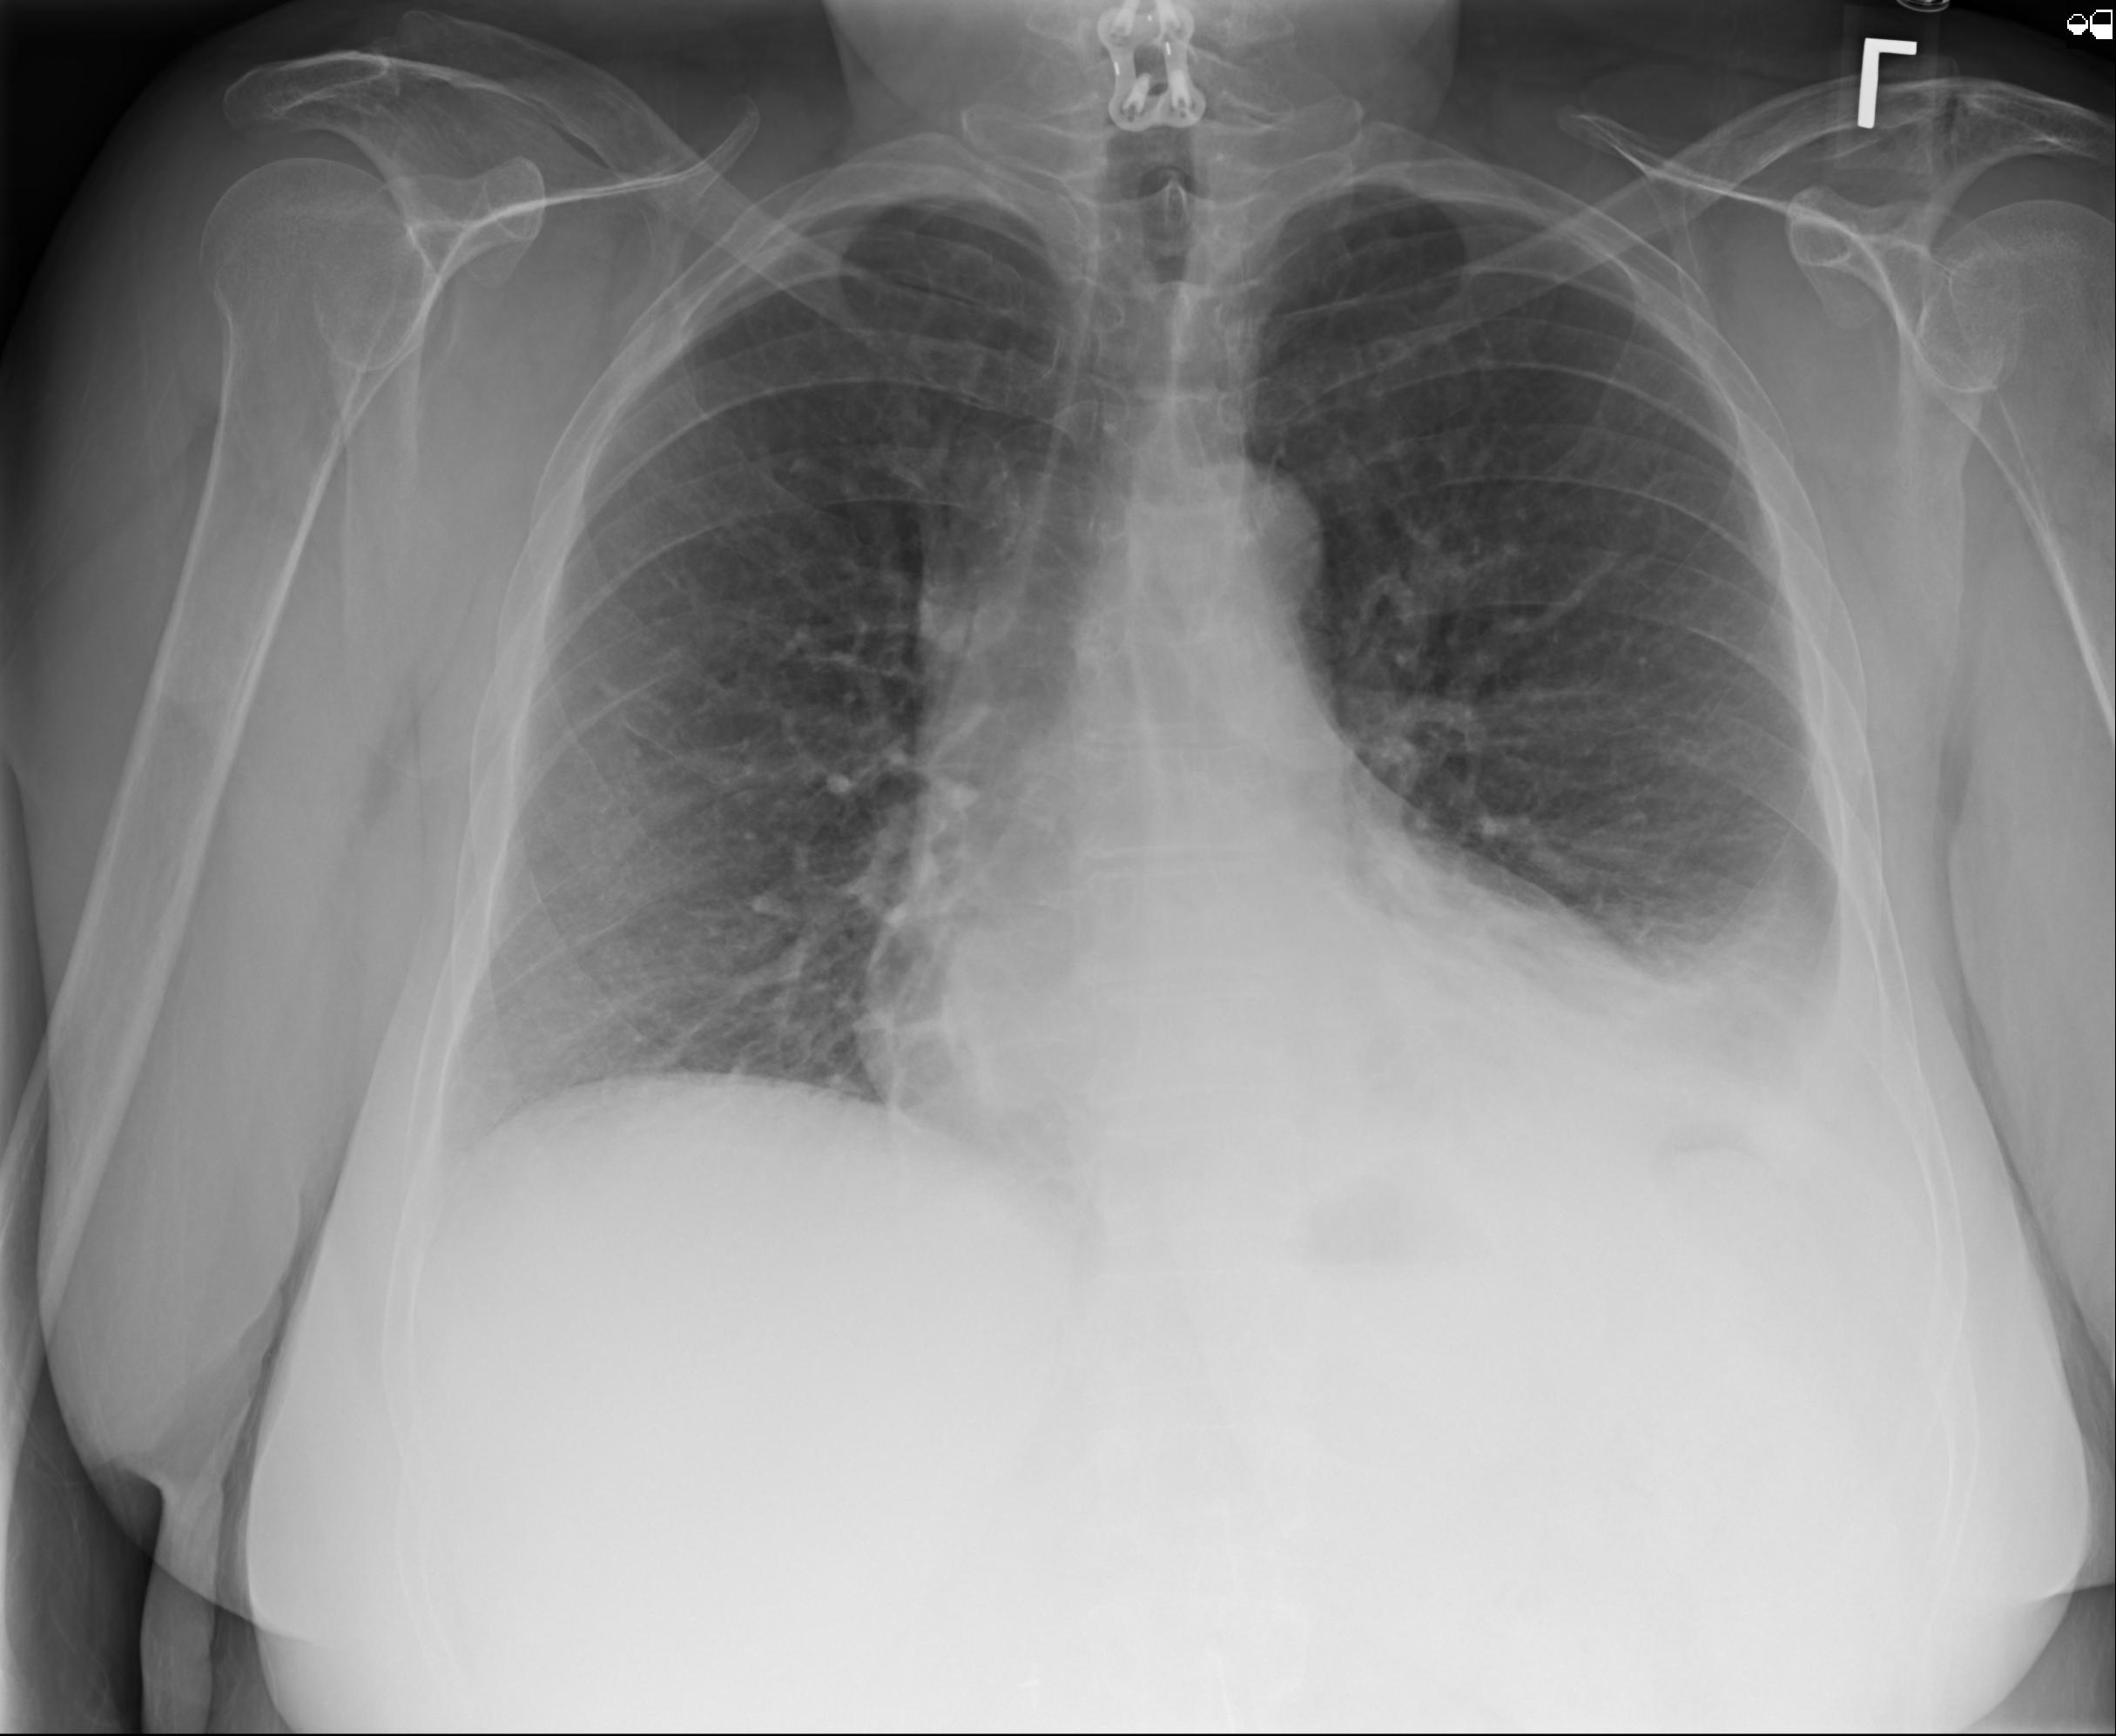

In [26]:
transformed_cxr_data[0]